# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like an LSTM, this is an example of a recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given starter code that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [ ]:
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook
import torch.nn.functional as f
import matplotlib.pyplot as plt

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [ ]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model_64.pth",
    save_dir= "/content/drive/MyDrive/Projects/", # give path here
    # Model hyper parameters
    char_embedding_size = 32,
    rnn_hidden_size= 64, # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	/content/drive/MyDrive/Projects/vectorizer.json
	/content/drive/MyDrive/Projects/model_64.pth
Using CUDA: True


### Initializations

In [ ]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
mask_index = vectorizer.char_vocab.mask_index


### Training loop

In [ ]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

In [44]:
# compute the loss & accuracy on the test set using the best available model
## Choosing the best model i.e RNN_HIDDEN_SIZE = 128

path = "/content/drive/MyDrive/Projects/model_128.pth"
model.load_state_dict(torch.load(path))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

**TODO**: Write code to compute the perplexity of the test corpus, the accuracy of a character-prediction task, and the perplexity of the predictive distribution given increasing amounts of context. For this last metric, you want to compute the perplexity of predicting the first character (given nothing to the left), the perplexity of predicting the second character (given the first), and so on, up to the perplexity of predicting the n-th character (given the first 1 to n-1 characters). Unlike an n-gram model, the recurrent model can encode arbitrarily long histories, although it will probably make more use of the nearby context.

In [45]:
# Segregating test prediction
test_pred = torch.Tensor()
true_pred = torch.LongTensor()

test_data=["test"]
for i in test_data:
  dataset.set_split(i)
  batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)
  model.eval()
  
  for batch_index, batch_dict in enumerate(batch_generator):
      y_pred = model(x_in=batch_dict['x_data'])
      test_pred=torch.cat((test_pred, y_pred.detach().cpu()))
      true_pred=torch.cat((true_pred, batch_dict['y_target'].detach().cpu()))

In [46]:
y_test_pred = test_pred.to(args.device)
y_test_pred_copy = test_pred.to(args.device)
y_test_true = true_pred.to(args.device)

In [47]:
def compute_loss(y_pred, y_true, mask_index):
  # Computing loss using CrossEntropy
  return f.cross_entropy(y_pred, y_true, ignore_index=mask_index,reduction='none')

In [48]:
###To calculate Perplexity
#code to compute the perplexity of the test text corpus
y_pred, y_true = normalize_sizes(y_test_pred, y_test_true)

loss = compute_loss(y_pred, y_true, mask_index)
pp = loss.view(-1,y_test_pred_copy.shape[1])
pp = pp.sum(axis=1)
perp=2**(pp/y_test_pred_copy.shape[1])
perp_avg=perp.sum()/y_test_pred_copy.shape[0]

print("Average perplexity:", perp_avg)

Average perplexity: tensor(1.9762, device='cuda:0')


Text(0, 0.5, 'Accuracy on Test set')

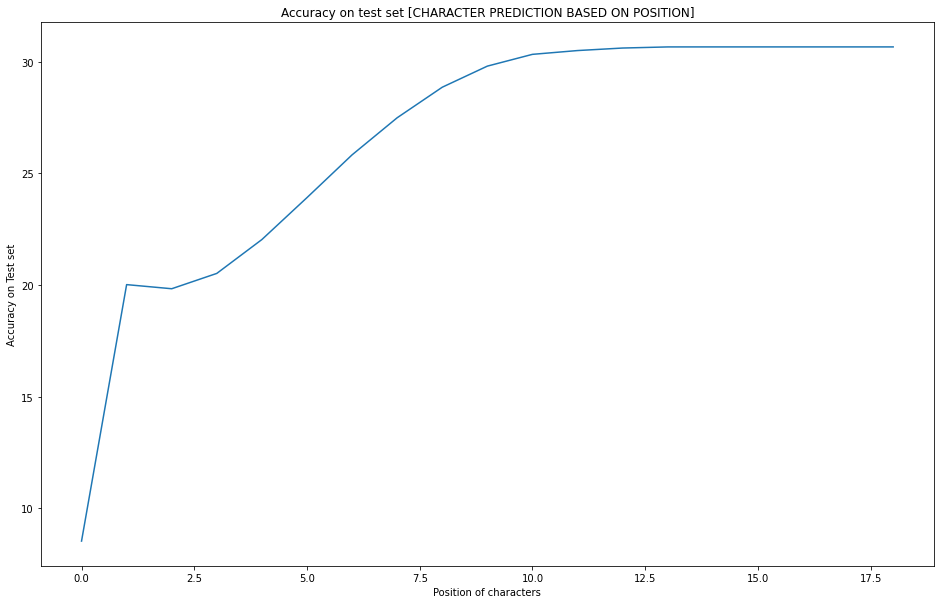

In [49]:
#code to compute the accuracy of a character-prediction task

def char_accuracy(y_pred,y_true,mask_index,pos):
    y_pred = y_test_pred[:,:pos,:]
    y_true = y_test_true[:,:pos]
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    accuracy = compute_accuracy(y_pred, y_true, mask_index)
    return accuracy

acc_pred = []
for j in range(1,y_test_pred.shape[1]+1):
  acc_pred.append(char_accuracy(y_test_pred, y_test_true, mask_index, j))
 
# Plot of character-prediction task based on position
plt.figure(figsize=(16,10))
plt.plot(np.arange(19),acc_pred)
plt.title("Accuracy on test set [CHARACTER PREDICTION BASED ON POSITION]")
plt.xlabel("Position of characters")
plt.ylabel("Accuracy on Test set")

Text(0.5, 1.0, 'Average Perplexity on test set [CHARACTER PREDICTION BASED ON POSITION]')

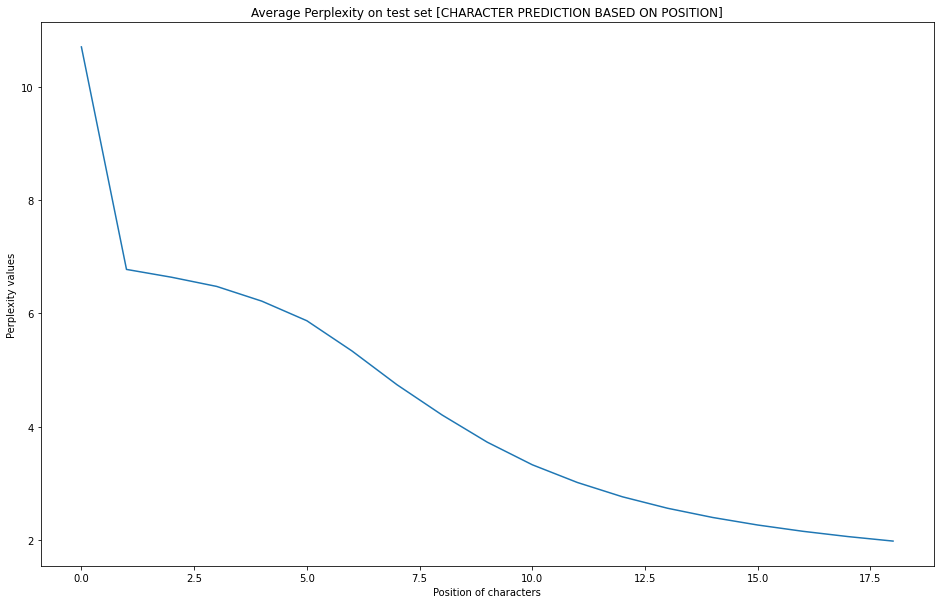

In [50]:
#code to compute the perplexity at a given character position (1, 2, 3, ...)
def position_perplexity(y_pred,y_true,mask_index,pos=-1):
  y_pred_1 = y_pred
  if pos==-1:
    pos=y_pred.shape[1]
  y_pred=y_pred[:,:pos,:]
  y_true=y_true[:,:pos]
  
  y_pred, y_true = normalize_sizes(y_pred, y_true)

  loss = compute_loss(y_pred, y_true, mask_index)
  pp = loss.view(-1,pos)
  pp=pp.sum(axis=1)
  perp=2**(pp/pos)
  perp_avg_pos=perp.sum()/y_test_pred_copy.shape[0]
  return perp_avg_pos

perplexity = []
for j in range(1,y_test_pred_copy.shape[1]+1):
    perplexity.append(position_perplexity(y_test_pred, y_test_true, mask_index, j).data)

plt.figure(figsize=(16,10))
plt.plot(np.arange(19),perplexity)
plt.xlabel("Position of characters")
plt.ylabel("Perplexity values")
plt.title("Average Perplexity on test set [CHARACTER PREDICTION BASED ON POSITION]")

In [51]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(perp_avg)) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.3141541679700217;
Test perplexity: 1.976243495941162;
Test Accuracy: 31.431884654886545


## Inference
To see the names that the model generates:

In [52]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Beh
Browal
Samher
Sanal
Assoi
Baury
Desuman
Jorqais
Mawosin
Grete


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

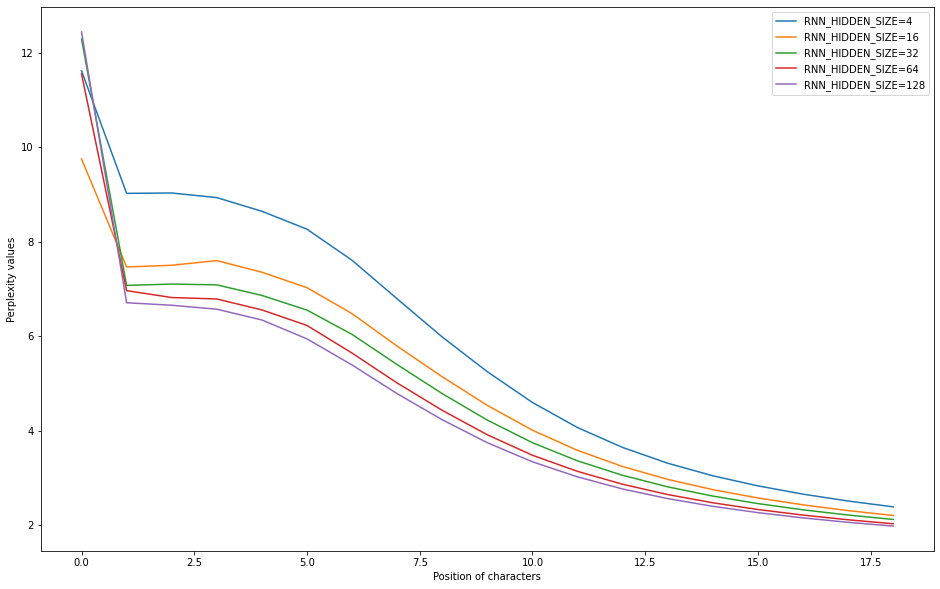

In [53]:
test_pred = torch.LongTensor()
true_pred = torch.LongTensor()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                    batch_size=args.batch_size, 
                                    device=args.device)

  
for batch_index, batch_dict in enumerate(batch_generator):
      test_pred=torch.cat((test_pred,batch_dict['x_data'].detach().cpu()))
      true_pred=torch.cat((true_pred,batch_dict['y_target'].detach().cpu()))

hidden_sizes = [4,16,32,64, 128]
perplexity = []
pre="/content/drive/MyDrive/Projects/model_"
post='.pth'
for i in hidden_sizes:

  path=pre+str(i)+post
  args.rnn_hidden_size=i
  model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)
  
  model.load_state_dict(torch.load(path))
  model.to(args.device)
  model.eval()
  y_pred = model(x_in = test_pred.to(args.device))
  perp=[]
  for j in range(1,y_pred.shape[1]+1):
    perp.append(position_perplexity(y_pred, true_pred.to(args.device), mask_index, j).data)
  perplexity.append(perp)

plt.figure(figsize=(16,10))
plt.xlabel("Position of characters")
plt.ylabel("Perplexity values")

for each,value in enumerate(perplexity):
  plt.plot(np.arange(len(value)),value,label="RNN_HIDDEN_SIZE={}".format(hidden_sizes[each]))
  plt.legend()





## Inference from the Perplexity value VS Position of Characters curve

 

1.   From the above plotted curve we can clearly observe for all variations in hidden sizes the perplexity is decreasing when the character positions increases which clearly suggests that model will predict more accurately when it has seen more characters. Similar inference we can make on Accuracy VS Position of Characters plot. 
2.   If we consider different levels of RNN_HIDDEN_SIZE, we can conclude that as the hidden_size parameter increases for a same character position, the perplexity value is relatively less or I would say better. This also justifies the fact that recurrent model can arbitarily memorize long sequence of texts.